### Setup

In [11]:
# Imports
import os
import pyxdf
import numpy as np
import mne
from scipy.signal import resample
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt

# Set global verbosity level to 'ERROR'
mne.set_log_level('ERROR')

# Load the file
data_session, header_session = pyxdf.load_xdf("test.xdf")

### Display File Info

In [25]:
# Display file header information
print("File Header Information:")

for key, value in header_session.items():
    print(f"{key}: {value}")

print()
    
# Iterate through the streams and display their information
for i, stream in enumerate(data_session):
    name = stream['info']['name'][0]
    stream_type = stream['info']['type'][0]
    channel_count = int(stream['info']['channel_count'][0])
    nominal_srate = float(stream['info']['nominal_srate'][0])
    effective_srate = float(stream['info']['effective_srate'])
        
    print(f"Stream {i + 1}:")
    print(f"  Name: {name}")
    print(f"  Type: {stream_type}")
    print(f"  Channel Count: {channel_count}")
    print(f"  Nominal Sampling Rate: {nominal_srate}")
    print(f"  Effective Sampling Rate: {effective_srate}")
        
    time_series = stream['time_series']
    num_samples = len(time_series)
    data_shape = (num_samples, channel_count)
        
    print(f"  Data Shape: {data_shape}")
    print(f"  Number of Samples: {num_samples}")
        
    if 'time_stamps' in stream:
        time_stamps = stream['time_stamps']
        print(f"  Time Stamps: {time_stamps[:5]}...")
        
    print()


File Header Information:
info: defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-02-01T14:42:33-0800']})

Stream 1:
  Name: CGX AIM Phys. Mon. AIM-0106 Impedance
  Type: Impeadance
  Channel Count: 13
  Nominal Sampling Rate: 500.0
  Effective Sampling Rate: 501.2018916265728
  Data Shape: (1662973, 13)
  Number of Samples: 1662973
  Time Stamps: [1977088.93361489 1977088.9356101  1977088.9376053  1977088.93960051
 1977088.94159571]...

Stream 2:
  Name: CGX AIM Phys. Mon. AIM-0106
  Type: EEG
  Channel Count: 13
  Nominal Sampling Rate: 500.0
  Effective Sampling Rate: 501.2018914810718
  Data Shape: (1662973, 13)
  Number of Samples: 1662973
  Time Stamps: [1977088.93361425 1977088.93560945 1977088.93760466 1977088.93959986
 1977088.94159506]...

Stream 3:
  Name: BrainAmpSeries-Dev_1
  Type: EEG
  Channel Count: 64
  Nominal Sampling Rate: 500.0
  Effective Sampling Rate: 499.9754830829712
  Data Shape: (1578112, 64)
  Number of Samples: 1578112
  Time Stamps: [197

### Visualize File Data

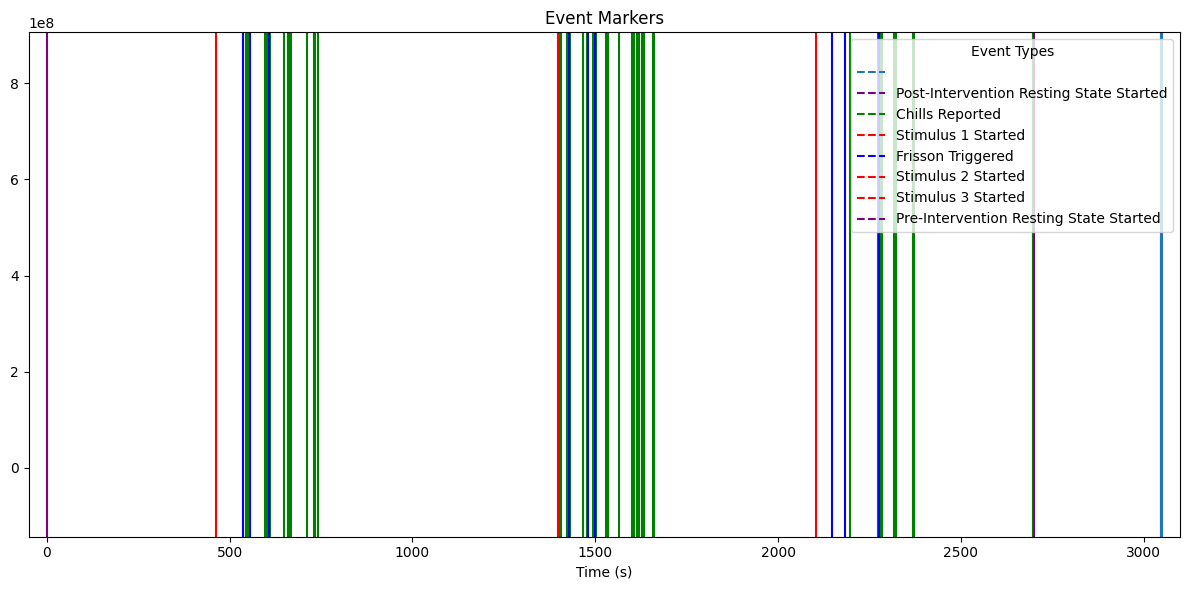

In [27]:
events = []

# Define a color map for different event types
colors = {
    'Pre-Intervention Resting State Started': 'purple',
    'Post-Intervention Resting State Started': 'purple',
    'Chills Reported': 'green',
    'Frisson Triggered': 'blue',
    'Stimulus 1 Started': 'red',
    'Stimulus 2 Started': 'red',
    'Stimulus 3 Started': 'red'
}

# Find the start time for pre-intervention resting state, stimuli start times, and post-intervention resting state
pre_intervention_start_time = None
stimulus_1_start_time = None
stimulus_2_start_time = None
stimulus_3_start_time = None
post_intervention_start_time = None

for stream in data_session:
    if isinstance(stream['time_series'], list):
        for timestamp, marker in zip(stream['time_stamps'], stream['time_series']):
            if marker[0] == 'Pre-Intervention Resting State Started':
                pre_intervention_start_time = timestamp
            if marker[0] == 'Stimulus 1 Started':
                stimulus_1_start_time = timestamp
            if marker[0] == 'Stimulus 2 Started':
                stimulus_2_start_time = timestamp
            if marker[0] == 'Stimulus 3 Started':
                stimulus_3_start_time = timestamp
            if marker[0] == 'Post-Intervention Resting State Started':
                post_intervention_start_time = timestamp

    if pre_intervention_start_time is not None and stimulus_1_start_time is not None and stimulus_2_start_time is not None and stimulus_3_start_time is not None and post_intervention_start_time is not None:
        break

if pre_intervention_start_time is None:
    raise RuntimeError('Pre-Intervention Resting State Started event not found')
if stimulus_1_start_time is None:
    raise RuntimeError('Stimulus 1 Started event not found')
if stimulus_2_start_time is None:
    raise RuntimeError('Stimulus 2 Started event not found')
if stimulus_3_start_time is None:
    raise RuntimeError('Stimulus 3 Started event not found')
if post_intervention_start_time is None:
    raise RuntimeError('Post-Intervention Resting State Started event not found')

# Create a plot
plt.figure(figsize=(12, 6))

for stream in data_session:
    y = stream['time_series']

    if isinstance(y, list):
        for timestamp, marker in zip(stream['time_stamps'], y):
            adjusted_time = timestamp - pre_intervention_start_time
            event_type = marker[0]  # Assume the first character represents the event type
            color = colors.get(event_type) 
            plt.axvline(x=adjusted_time, linestyle='-', color=color)
            events.append((event_type, adjusted_time, color))
    elif isinstance(y, np.ndarray):
        # Display data as lines
        plt.plot(stream['time_stamps'], y)
    else:
        raise RuntimeError('Unknown stream format')

# Set x-axis limits
plt.xlim(-50, max(event[1] for event in events) + 50) 

# Set plot labels and title
plt.xlabel('Time (s)')
plt.ylabel('')
plt.title('Event Markers')

# Create legend
unique_events = set(event[0] for event in events)
handles = [plt.Line2D([0], [0], color=colors.get(event_type), linestyle='--', label=event_type) for event_type in unique_events]
plt.legend(handles=handles, title='Event Types', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


### Processing

In [24]:
# Initialize the sessions
raw_sessions = []

# Define the time ranges for the three sessions
time_ranges = [(stimulus_1_start_time, stimulus_1_start_time + 300), (stimulus_2_start_time, stimulus_2_start_time + 300), (stimulus_3_start_time, stimulus_3_start_time + 300)]

# Define the baseline time ranges
baseline_time_ranges = [(0, 300), (post_intervention_start_time - pre_intervention_start_time, post_intervention_start_time - pre_intervention_start_time + 300)]

# Extract EEG data
for session_index, time_range in enumerate(time_ranges):
    eeg_data = []
    eeg_ch_names = []

    for stream in data_session:
        stream_name = stream["info"]["name"][0]

        if stream_name == "BrainAmpSeries-Dev_1":
            eeg_data.append(stream["time_series"])
            eeg_ch_names.extend([ch["label"][0] for ch in stream["info"]["desc"][0]["channels"][0]["channel"]])
            sfreq = int(round(float(stream["info"]["nominal_srate"][0])))

    if not eeg_data:
        raise ValueError(f"No EEG data found in XDF file for session {session_index+1}")

    # Convert EEG data to numpy array and transpose it
    eeg_data = np.array(eeg_data[0]).T 

    # Create MNE Info object
    info = mne.create_info(ch_names=eeg_ch_names, sfreq=sfreq, ch_types='eeg')

    # Create MNE Raw object
    raw = mne.io.RawArray(eeg_data, info)

    # Get the timestamps for the EEG and markers streams
    eeg_time_stamps = data_session[0]['time_stamps']
    marker_time_stamps = data_session[2]['time_stamps'] 

    # Define the overlap range for the current session
    overlap_start, overlap_end = time_range

    # Filter EEG data to only include overlapping timestamps
    eeg_indices = np.where((eeg_time_stamps >= overlap_start) & (eeg_time_stamps <= overlap_end))[0]
    eeg_data = eeg_data[:, eeg_indices]
    eeg_time_stamps = eeg_time_stamps[eeg_indices]

    # Update raw data
    raw = mne.io.RawArray(eeg_data, info)

    # Find the corresponding marker data
    marker_data = []
    marker_times = []

    for j, timestamp in enumerate(marker_time_stamps):
        if overlap_start <= timestamp <= overlap_end:
            marker_data.append(data_session[2]['time_series'][j])
            marker_times.append(timestamp)

    # Convert marker data and times to numpy array
    marker_data = np.array(marker_data)
    marker_times = np.array(marker_times) - overlap_start  

    # Flatten the marker_data
    marker_data_flat = [item for sublist in marker_data for item in sublist]

    # Create a list of tuples (timestamp, marker_data)
    timestamp_marker_data_tuples = list(zip(marker_times, marker_data_flat))

    # Identify annotations that fall outside the EEG data duration
    eeg_duration = raw.times[-1] 

    # Select tuples where the timestamp is out of range
    out_of_range_annotations = [t for t in timestamp_marker_data_tuples if t[0] > eeg_duration]

    if out_of_range_annotations:
        # Print out the out-of-range annotations
        print(f'Session {session_index+1} - The following annotations were omitted because they fall outside the EEG data duration:')
        for annotation in out_of_range_annotations:
            print(f'time={annotation[0]}, annotation={annotation[1]}')
    else:
        print(f'Session {session_index+1} - No annotations were omitted.')

    # Create annotations in batches
    batch_size = 1000 
    num_batches = (len(marker_times) + batch_size - 1) // batch_size

    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, len(marker_times))
        batch_marker_times = marker_times[start_index:end_index]
        batch_marker_data_flat = marker_data_flat[start_index:end_index]

        # Create annotations for the current batch
        annotations = mne.Annotations(batch_marker_times, np.repeat(0, len(batch_marker_times)), batch_marker_data_flat)

        # Add annotations to the raw data
        raw.set_annotations(annotations)

    # Handle baseline data
    baseline_data = []

    for baseline_range in baseline_time_ranges:
        baseline_start, baseline_end = baseline_range
        baseline_indices = np.where((eeg_time_stamps >= baseline_start) & (eeg_time_stamps <= baseline_end))[0]

        if baseline_indices.size > 0:
            baseline_eeg_data = eeg_data[:, baseline_indices]
            baseline_data.append(baseline_eeg_data)

    # Concatenate baseline data and session data
    if baseline_data:
        baseline_data = np.concatenate(baseline_data, axis=1)
        combined_data = np.concatenate((baseline_data, eeg_data), axis=1)
    else:
        combined_data = eeg_data

    # Update raw data with combined data
    raw = mne.io.RawArray(combined_data, info)

    raw_sessions.append(raw)

Session 1 - No annotations were omitted.
Session 2 - No annotations were omitted.
Session 3 - No annotations were omitted.


### Before and After ICA Output

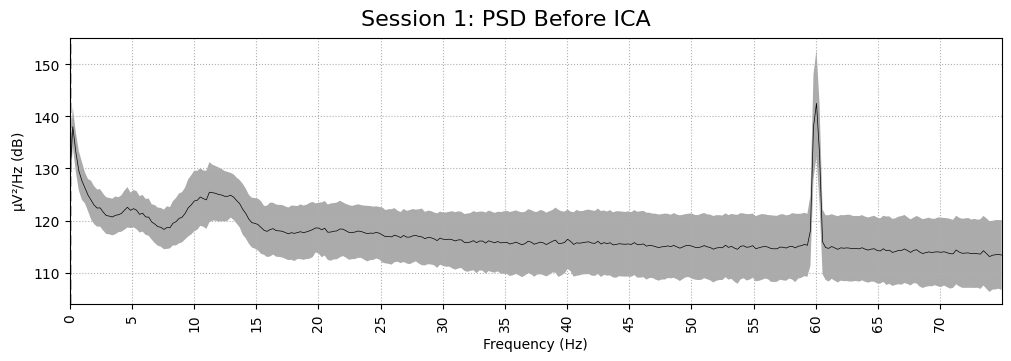

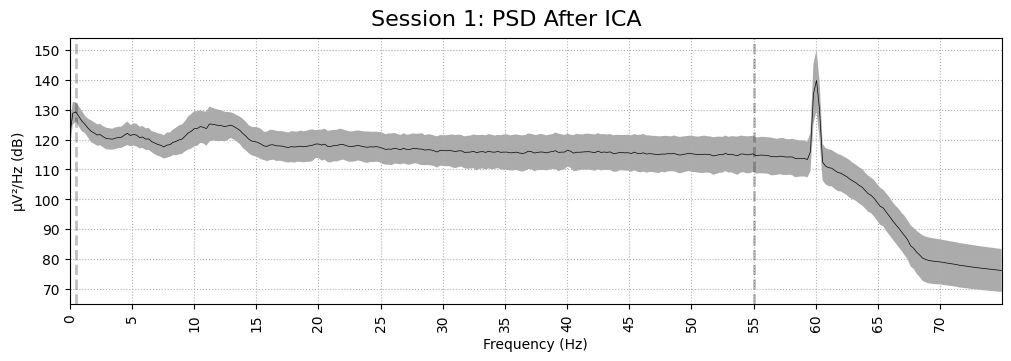

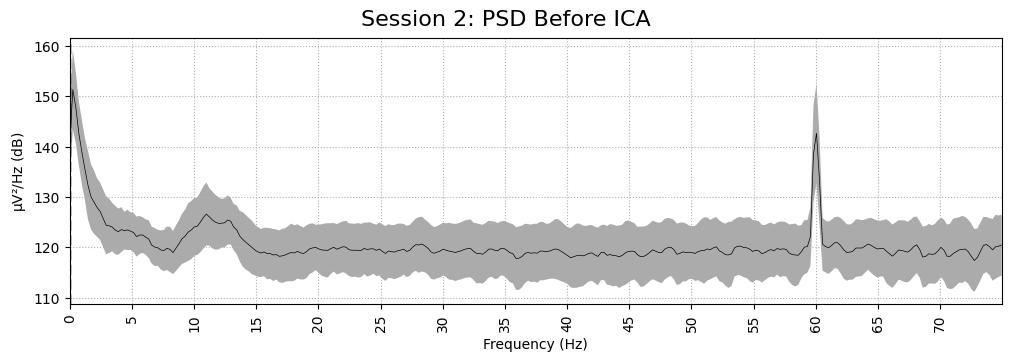

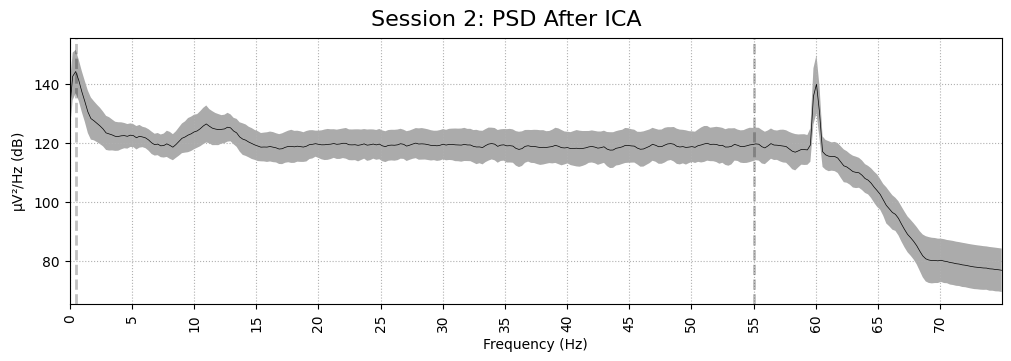

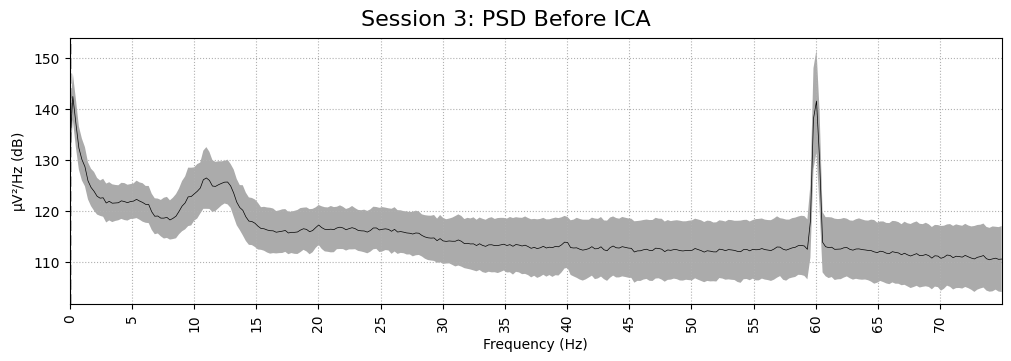

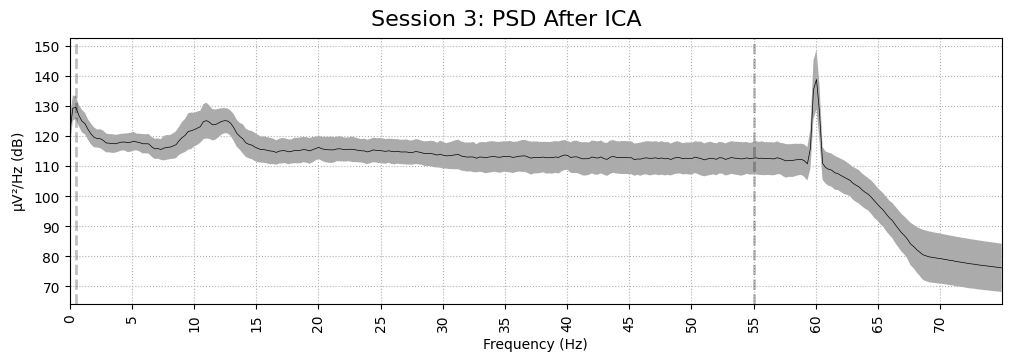

In [22]:
# Calculate x-ticks position and labels
freq_ticks = list(range(0, 71, 5)) 
freq_labels = [str(f) for f in freq_ticks]

for i, raw in enumerate(raw_sessions):
    try:
        # Plot PSD before ICA
        fig = raw.plot_psd(fmin=0, fmax=75, average=True, show=False)  # limit the frequency range
        fig.axes[0].set_title('')
        fig.suptitle(f'Session {i+1}: PSD Before ICA', fontsize=16)
        plt.xticks(freq_ticks, freq_labels, rotation=90)
        plt.show()

        # Set montage
        montage = make_standard_montage('standard_1005')
        raw.set_montage(montage)

        # Apply firwin filter
        raw.filter(0.5, 55, fir_design='firwin')

        # Apply ICA
        n_components = int(raw.copy().pick_types(eeg=True, exclude='bads').info['nchan'])
        ica = mne.preprocessing.ICA(n_components=n_components, method='fastica', random_state=42)
        ica.fit(raw)

        # Detect and remove artifacts
        proxy_channels = ['Fp1', 'Fp2', 'F7', 'F8', 'T7', 'T8']
        ica.exclude = []

        for ch in proxy_channels:
            inds, _ = ica.find_bads_eog(raw, ch_name=ch)
            ica.exclude += inds
            
        ica.apply(raw)

        # Interpolate bad channels
        raw.interpolate_bads(reset_bads=True)

        # Plot PSD after ICA
        fig = raw.plot_psd(fmin=0, fmax=75, average=True, show=False)  # limit the frequency range
        fig.axes[0].set_title('')
        fig.suptitle(f'Session {i+1}: PSD After ICA', fontsize=16)
        plt.xticks(freq_ticks, freq_labels, rotation=90)
        plt.show()

    except Exception as e:
        print(f"Preprocessing for session {i+1} failed with error: {e}")


### Raw Data Output

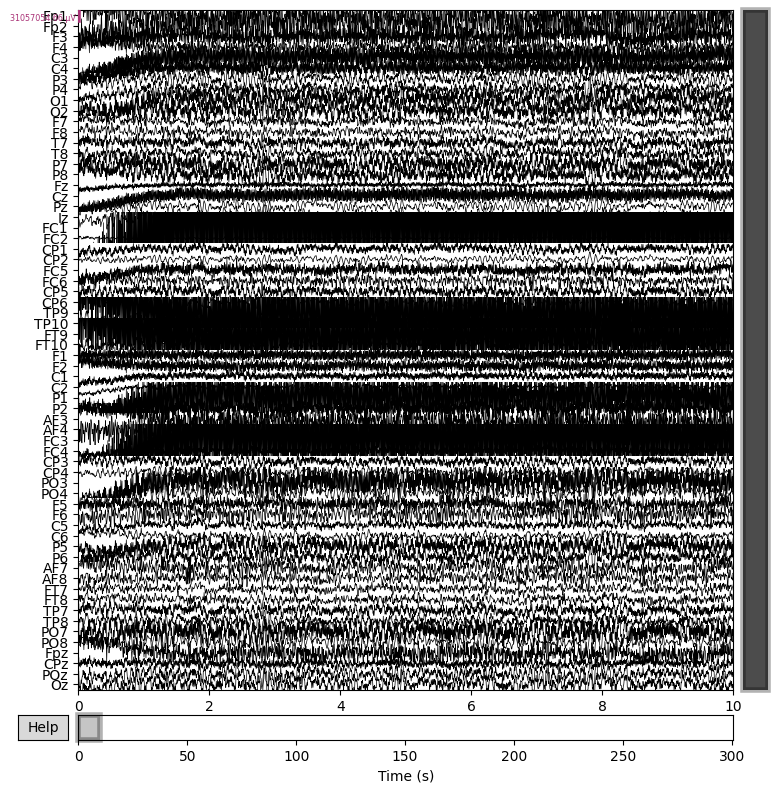

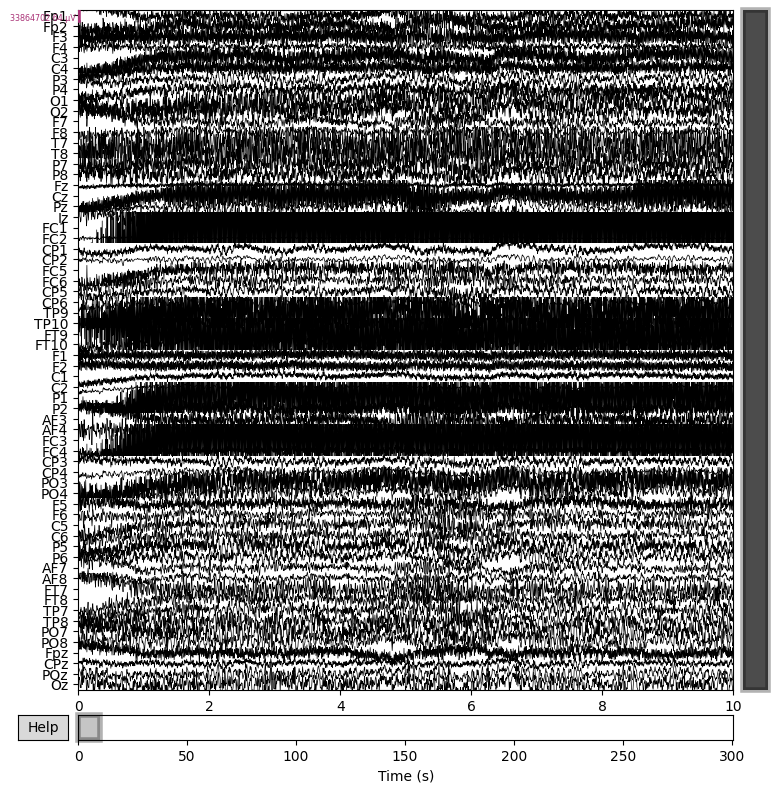

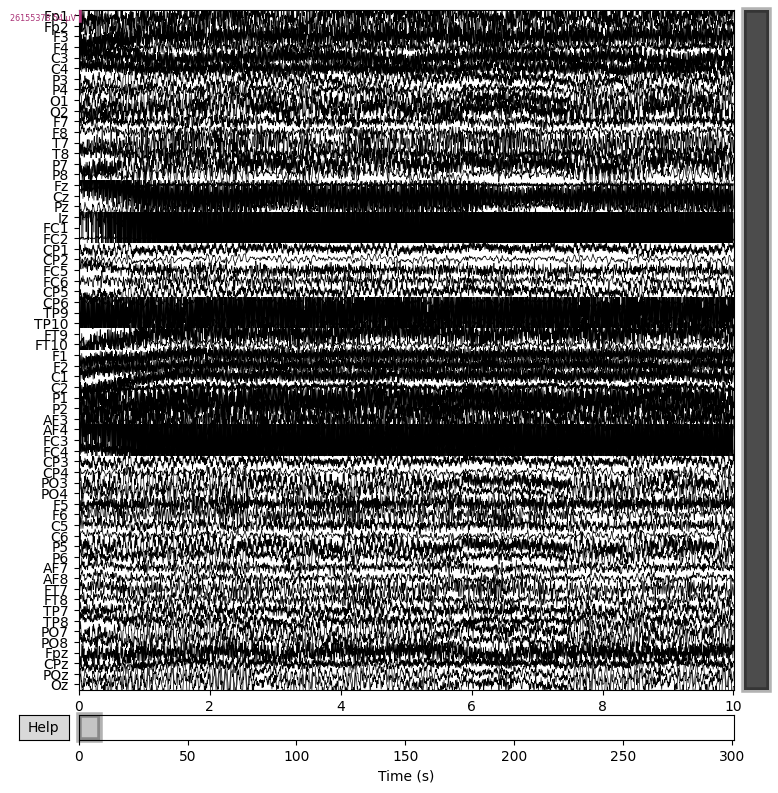

In [23]:
# Output raw data from all channels
for session in raw_sessions:
    session.plot(start=0, n_channels=64, scalings='auto', show=True, block=True)